In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
from contextily import add_basemap
from rasterio import windows
from scipy.stats import mode
from skimage.exposure import rescale_intensity
from skimage.segmentation import slic

In [6]:
# Data parameter
s1_aceh_before = "https://storage.googleapis.com/gee-ramiqcom-bucket/banjir_indonesia/sentinel-1/aceh_2025-11-21_S1_RTC_composite_2025-11-20_2025-11-22_10m.tif"
s1_aceh_after = "https://storage.googleapis.com/gee-ramiqcom-bucket/banjir_indonesia/sentinel-1/aceh_2025-11-28_S1_RTC_composite_2025-11-27_2025-11-29_10m.tif"
roi = "https://storage.googleapis.com/gee-ramiqcom-bucket/banjir_indonesia/rois/flood_aceh_rois.geojson"

In [27]:
# Data dictionary
data_dict = [
    dict(name="Before", date="2025-11-21", s1=s1_aceh_before),
    dict(name="After", date="2025-11-28", s1=s1_aceh_after),
]

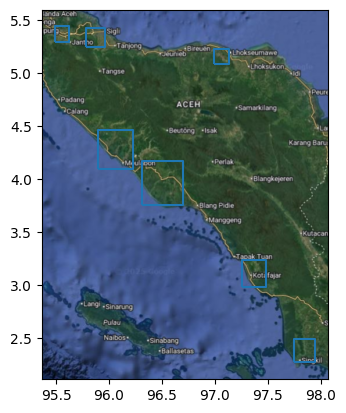

In [116]:
# Plot region of interest
df_roi = gpd.read_file(roi)
ax = df_roi.boundary.plot()
add_basemap(
    ax,
    crs="EPSG:4326",
    source="http://mt0.google.com/vt/lyrs=y&hl=en&x={x}&y={y}&z={z}",
)

In [ ]:
# selected_roi
for y in range(len(df_roi)):
    roi_select = df_roi.iloc[y : y + 1]
    location = roi_select.iloc[0]["name"]
    bbox = tuple(roi_select.total_bounds)
    min_x, min_y, max_x, max_y = bbox
    layer_extent = (min_x, max_x, min_y, max_y)
    fig = plt.figure(figsize=(15, 5))

    # define ideal shape
    resolution = 10
    width = int(abs(bbox[0] - bbox[2]) * 111_000 / resolution)
    height = int(abs(bbox[1] - bbox[3]) * 111_000 / resolution)
    shape = (height, width)

    # data dict after clip
    images = dict()

    for x in range(len(data_dict)):
        data_info = data_dict[x]
        name = data_info["name"]
        date = data_info["date"]
        path = data_info["s1"]

        # load image
        with rio.open(path) as src:
            window = windows.from_bounds(*bbox, transform=src.transform)
            s1 = src.read(window=window, out_shape=shape)
            vv, vh = s1
            rdi = (vv / 1e4 - vh / 1e4) / (vv / 1e4 + vh / 1e4)
            composite_s1 = np.dstack(
                [
                    rescale_intensity(vv, in_range=(1000, 3000), out_range=(0, 255)),
                    rescale_intensity(vh, in_range=(0, 1000), out_range=(0, 255)),
                    rescale_intensity(rdi, in_range=(0.5, 1), out_range=(0, 255)),
                ]
            ).astype("uint8")

            ax2 = fig.add_subplot(1, 3, x + 1)
            ax2.set_title(f"Sentinel-1 {name} ({date})")
            ax2.imshow(composite_s1, extent=layer_extent)

            # generate water mask
            water = (vv < 800) * (vh < 300) * 1
            segment = slic(composite_s1 / 255, n_segments=10000, compactness=5, sigma=5)
            unique = np.unique(segment)
            water_segment = segment.copy()

            for val in unique:
                water_segment[segment == val] = mode(water[segment == val], axis=0).mode

            images[name] = dict(vv=vv, vh=vh, rdi=rdi, water=water_segment)

    # Flood map
    flood_map = (images["Before"]["water"] == 0) & (images["After"]["water"] == 1)
    flood_area = (np.sum(flood_map) * 900 / 10_000).astype("uint32")
    flood_map = flood_map.astype("float32")
    flood_map[flood_map == 0] = np.nan

    ax3 = fig.add_subplot(1, 3, 3)
    roi_select.boundary.plot(ax=ax3)
    ax3.set_title(f"Flood in {location}: {(f'{flood_area:,}').replace(',', ' ')} Ha")
    add_basemap(
        ax=ax3,
        crs="EPSG:4326",
        source="http://mt0.google.com/vt/lyrs=y&hl=en&x={x}&y={y}&z={z}",
    )
    ax3.imshow(
        flood_map, extent=layer_extent, cmap="Blues", zorder=9999, vmin=0, vmax=2
    )
    fig.tight_layout()

    plt.close(fig)

C:\Users\ramiq\AppData\Local\Temp\ipykernel_24704\4188031294.py:30: RuntimeWarning: invalid value encountered in divide
  rdi = (vv / 1e4 - vh / 1e4) / (vv / 1e4 + vh / 1e4)
C:\Users\ramiq\AppData\Local\Temp\ipykernel_24704\4188031294.py:37: RuntimeWarning: invalid value encountered in cast
  ).astype("uint8")
